In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import warnings

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")
warnings.simplefilter(action="ignore", category=FutureWarning)

# TEOTIL3 Trondheimsfjorden

# Part 4: Hotranelva load uncertainty

Exploring the effect of sampling frequency on observed flux estimates.

In [3]:
# Read chem
wc_df = pd.read_excel(r"../data/hotran_totn_totp_vannmiljo.xlsx")
wc_df["date"] = pd.to_datetime(pd.to_datetime(wc_df["Tid_provetak"]).dt.date)
wc_df["par"] = wc_df["Parameter_id"] + "-" + wc_df["Filtrert_Prove"].str[0]
wc_df = wc_df[["date", "par", "Verdi"]]
wc_df = wc_df.groupby(["date", "par"]).mean().unstack("par")
wc_df.columns = wc_df.columns.get_level_values(1)
names_dict = {
    "N-TOT-U": "TOTN_ug/l",
    "P-TOT-F": "TDP_ug/l",
    "P-TOT-U": "TOTP_ug/l",
}
wc_df.rename(columns=names_dict, inplace=True)
wc_df.head()

par,TOTN_ug/l,TDP_ug/l,TOTP_ug/l
date,,,
1992-03-19,3060.0,37.0,142.0
1992-04-02,3820.0,26.0,212.0
1992-04-16,2200.0,39.0,72.0
1992-04-30,2330.0,40.0,69.0
1992-05-14,10600.0,60.0,192.0


In [4]:
# Filter outliers
outlier_thresh = 4
for col in wc_df.columns:
    par, unit = col.split("_")
    wc_df[f"{par}_outlier"] = utils.double_mad_from_median(
        wc_df[col].values, thresh=outlier_thresh
    )
out_cols = [col for col in wc_df.columns if col.endswith("_outlier")]
wc_df["sum_outlier"] = wc_df[out_cols].sum(axis="columns")

# remove samples with outliers
wc_df = wc_df.query("sum_outlier == 0")
out_cols = [col for col in wc_df.columns if col.endswith("_outlier")]
wc_df.drop(columns=out_cols, inplace=True)
wc_df.head()

par,TOTN_ug/l,TDP_ug/l,TOTP_ug/l
date,,,
1992-03-19,3060.0,37.0,142.0
1992-04-02,3820.0,26.0,212.0
1992-04-16,2200.0,39.0,72.0
1992-04-30,2330.0,40.0,69.0
1992-05-14,10600.0,60.0,192.0


<Axes: xlabel='year', ylabel='TOTP_ug/l'>

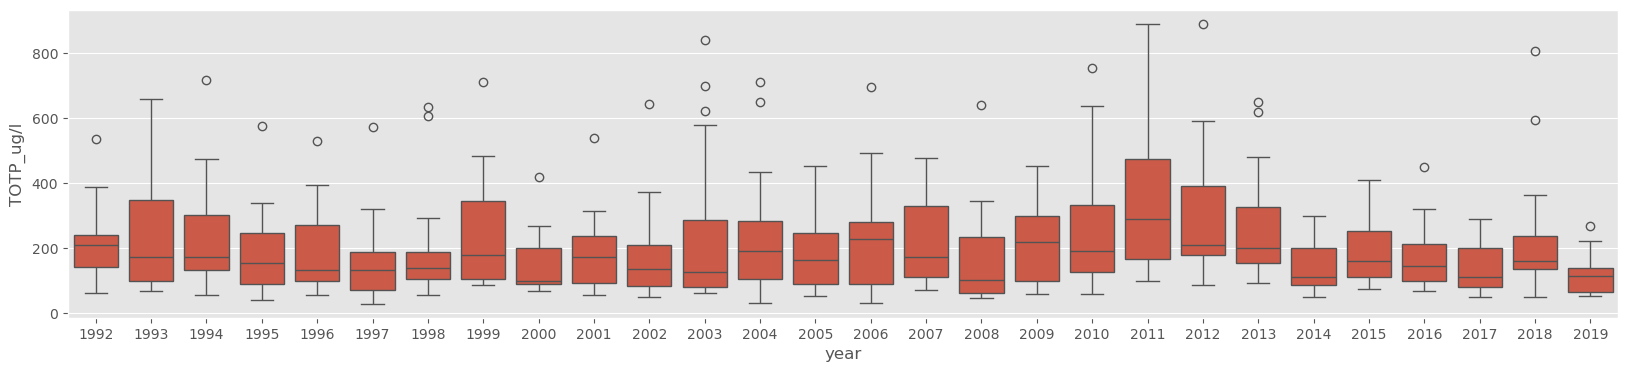

In [5]:
# Boxplots by year
wc_df["year"] = wc_df.index.year
fig = plt.figure(figsize=(20, 4))
sn.boxplot(data=wc_df, x="year", y="TOTP_ug/l")

<Axes: xlabel='year', ylabel='TDP_ug/l'>

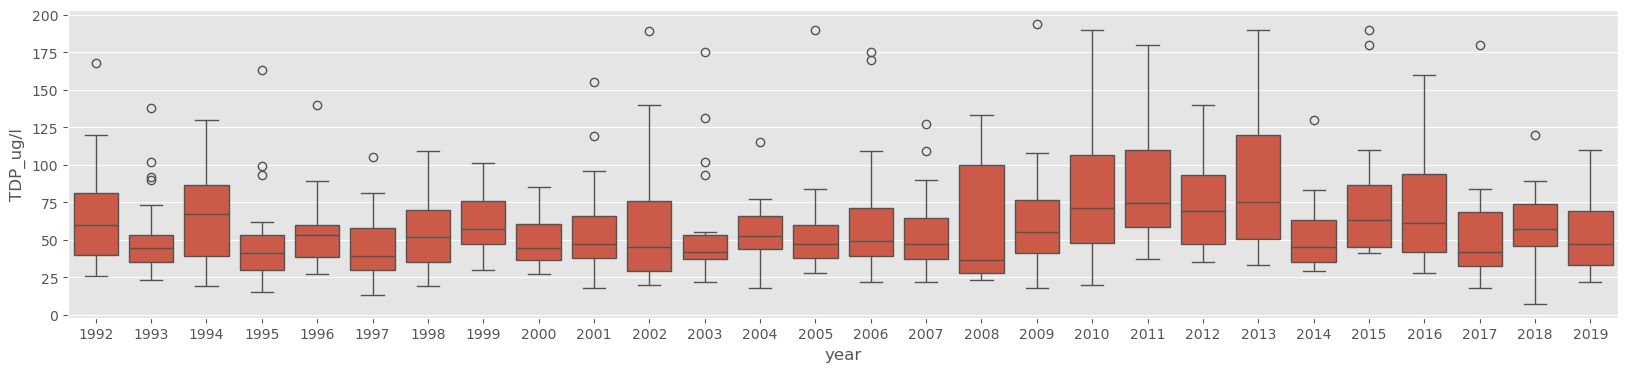

In [6]:
fig = plt.figure(figsize=(20, 4))
sn.boxplot(data=wc_df, x="year", y="TDP_ug/l")

<Axes: xlabel='year', ylabel='TOTN_ug/l'>

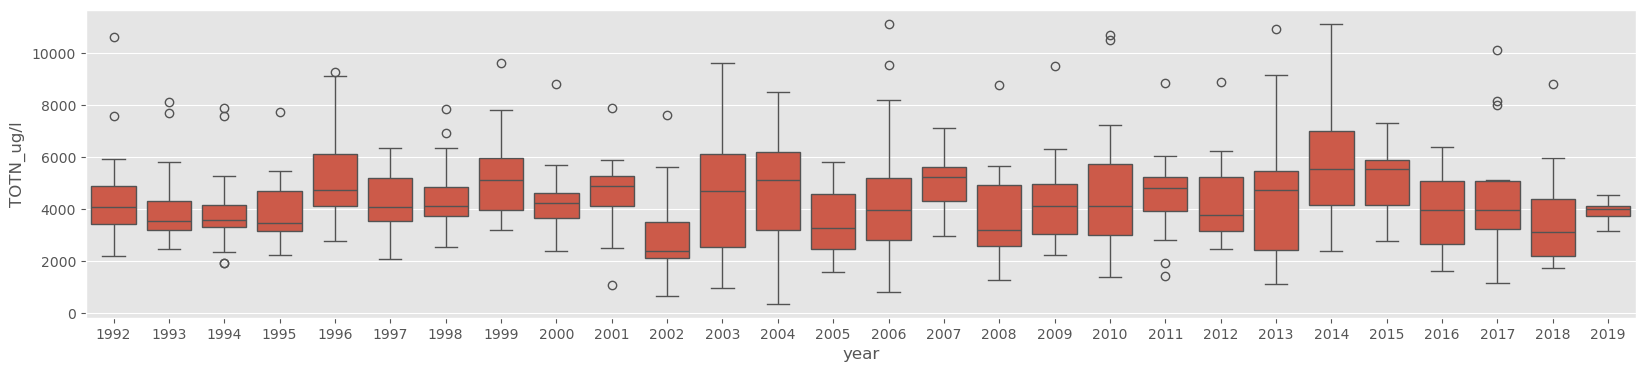

In [7]:
fig = plt.figure(figsize=(20, 4))
sn.boxplot(data=wc_df, x="year", y="TOTN_ug/l")

In [8]:
# Flow data for 2014 is bad. Remove concs too
wc_df = wc_df.query("year != 2014")
del wc_df["year"]

In [9]:
# Get flow
nve_id = "126.2.0"

q_df = nivapy.da.query_nve_hydapi(
    [nve_id], [1001], "1992-01-01", "2020-12-31", resolution=1440
)
q_df["date"] = pd.to_datetime(q_df["datetime"].dt.date)
q_df = q_df.set_index("date")[["value"]]
q_df.columns = ["flow_m3/s"]

# NVE data for 2014 is bad
q_df["year"] = q_df.index.year
q_df = q_df.query("year != 2014")
del q_df["year"]

q_df.head()

,flow_m3/s
date,
1997-12-28,0.035532
1997-12-29,0.033558
1997-12-30,0.031584
1997-12-31,0.029610
1998-01-01,0.323702


In [10]:
# Discharge monitoring starts in 1998;
# Near-complete chem from 1992 to 2018
# => period of interest from 1998-2018
wc_df = wc_df.truncate(before="1998-01-01", after="2018-12-31")
q_df = q_df.truncate(before="1998-01-01", after="2018-12-31")

wc_df = wc_df.truncate(before="2012-01-01", after="2018-12-31")
q_df = q_df.truncate(before="2012-01-01", after="2018-12-31")

In [11]:
# Reference fluxes
flux_df_raw = nivapy.stats.estimate_fluxes(
    q_df,
    wc_df,
    base_freq="D",
    agg_freq="A",
    method="ospar_annual",
    st_date=None,
    end_date=None,
    plot_fold=None,
).reset_index()
flux_df_raw = flux_df_raw.melt(id_vars="year", var_name="par")
flux_df_raw["freq"] = "raw"
flux_df_raw.head()

,year,par,value,freq
0,2012,TOTN_kg,32730.802087,raw
1,2013,TOTN_kg,51414.586589,raw
2,2014,TOTN_kg,NaN,raw
3,2015,TOTN_kg,101568.832827,raw
4,2016,TOTN_kg,54260.445748,raw


In [12]:
# Pick one sample per month at random
df_list = []
for i in range(200):
    wc_df_mon = wc_df.copy()
    wc_df_mon["agg"] = wc_df_mon.index.to_period("M")
    wc_df_mon = wc_df_mon.groupby("agg").apply(
        lambda x: x.sample(1), include_groups=False
    )
    wc_df_mon.index = wc_df_mon.index.get_level_values(1)

    # Fluxes using monthly
    flux_df_mon = nivapy.stats.estimate_fluxes(
        q_df,
        wc_df_mon,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
        st_date=None,
        end_date=None,
        plot_fold=None,
    ).reset_index()
    flux_df_mon = flux_df_mon.melt(id_vars="year", var_name="par")
    flux_df_mon["freq"] = "monthly"
    df_list.append(flux_df_mon)
flux_df_mon = pd.concat(df_list, axis="rows")
flux_df_mon.head()

,year,par,value,freq
0,2012,TOTN_kg,33489.615863,monthly
1,2013,TOTN_kg,66581.354346,monthly
2,2014,TOTN_kg,NaN,monthly
3,2015,TOTN_kg,85202.660997,monthly
4,2016,TOTN_kg,56510.697097,monthly


In [13]:
# Pick one sample per quarter at random
df_list = []
for i in range(200):
    wc_df_qtr = wc_df.copy()
    wc_df_qtr["agg"] = wc_df_qtr.index.to_period("Q")
    wc_df_qtr = wc_df_qtr.groupby("agg").apply(
        lambda x: x.sample(1), include_groups=False
    )
    wc_df_qtr.index = wc_df_qtr.index.get_level_values(1)

    # Fluxes using monthly
    flux_df_qtr = nivapy.stats.estimate_fluxes(
        q_df,
        wc_df_qtr,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
        st_date=None,
        end_date=None,
        plot_fold=None,
    ).reset_index()
    flux_df_qtr = flux_df_qtr.melt(id_vars="year", var_name="par")
    flux_df_qtr["freq"] = "quarterly"
    df_list.append(flux_df_qtr)
flux_df_qtr = pd.concat(df_list, axis="rows")
flux_df_qtr.head()

,year,par,value,freq
0,2012,TOTN_kg,27576.829138,quarterly
1,2013,TOTN_kg,49927.489085,quarterly
2,2014,TOTN_kg,NaN,quarterly
3,2015,TOTN_kg,98481.296686,quarterly
4,2016,TOTN_kg,54388.495882,quarterly


In [14]:
flux_df = pd.concat([flux_df_raw, flux_df_mon, flux_df_qtr], axis="rows").dropna(
    how="any"
)

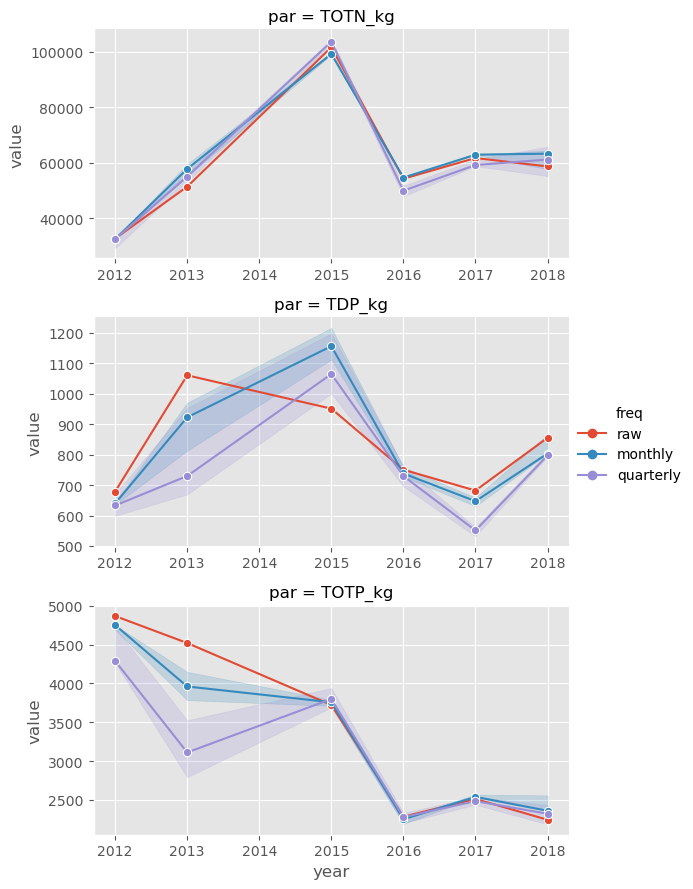

In [15]:
sn.relplot(
    data=flux_df,
    x="year",
    y="value",
    row="par",
    hue="freq",
    kind="line",
    marker="o",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": False},
    estimator="median",
    errorbar=("ci", 95),
)